In [1]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from datasets import load_dataset, concatenate_datasets
from peft import get_peft_model, get_peft_model_state_dict, set_peft_model_state_dict, LoraConfig, TaskType
from trl import SFTTrainer
import evaluate
import matplotlib.pyplot as plt

from utils import *

/home/edgelab/llm-workshop/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print(device)

cuda


We start by splitting up the dataset into 5 different partitions. Each hospital has access to only one biomedical category of the CARDBiomedBench dataset

In [3]:
dataset = load_dataset("NIH-CARD/CARDBiomedBench")

biomed_categories = [
    "Drug Gene Relations",
    "Pharmacology",
    "Drug Meta",
    "SNP Disease Relations",
    "SMR Gene Disease Relations"
]

train_datasets = []
test_datasets = []

for category in biomed_categories:
    filtered_train_ds = dataset["train"].filter(lambda x: x["bio_category"] == category)
    filtered_test_ds = dataset["test"].filter(lambda x: x["bio_category"] == category)
    filtered_train_ds = filtered_train_ds.shuffle(seed=42).select(range(1_000))
    filtered_test_ds = filtered_test_ds.shuffle(seed=42).select(range(100))
    train_datasets.append(filtered_train_ds)
    test_datasets.append(filtered_test_ds)
    
test_dataset = concatenate_datasets(test_datasets)

Filter: 100%|██████████| 10148/10148 [00:00<00:00, 145386.03 examples/s]


In [4]:
print(len(train_datasets))

5


Let's consider the case where hospitals are not collaborating. Each hospital fine-tunes their own LLM in a standard, centralized way

## Hospital 1: Centralized model (20% train data)

![Centralized Case](figures/centralized_case.png)

In [5]:
centralized_dataset = train_datasets[0]

In [6]:
# Load model and tokenizer
model = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model).to(device)

tokenizer.pad_token = tokenizer.eos_token 
model.config.pad_token_id = model.config.eos_token_id 

In [7]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    task_type=TaskType.CAUSAL_LM,
)

lora_model = get_peft_model(model, lora_config)

In [8]:
lora_model.print_trainable_parameters()

trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


## Centralized Fine-tuning

In [9]:
mapped_train_dataset = centralized_dataset.map(
    generate_instruction_format,
    remove_columns=centralized_dataset.column_names,
    batched=False,
)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 10431.28 examples/s]


In [10]:
model.train()

training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=5e-4,
    logging_steps=20,
    save_total_limit=2,
    use_cpu=not(use_cuda)
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=mapped_train_dataset
)

trainer.train()

Truncating train dataset: 100%|██████████| 1000/1000 [00:00<00:00, 298760.88 examples/s]


Step,Training Loss
20,2.367900
40,1.555800
60,0.983300
80,0.815300


TrainOutput(global_step=96, training_loss=1.3211827079455059, metrics={'train_runtime': 73.8329, 'train_samples_per_second': 40.632, 'train_steps_per_second': 1.3, 'total_flos': 196176046321152.0, 'train_loss': 1.3211827079455059})

## Evaluation

In [11]:
def get_predictions(example):
    instruction = "You are a knowledgeable assistant. Answer this question truthfully!"

    question = example["question"]

    # format the input the same way as during training
    prompt = (
        "### Instruction:\n"
        f"{instruction}\n\n"
        "### Input:\n"
        f"{question}\n\n"
        "### Response:\n"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # generate
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
        )

    predicted_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # removes the prompt from the response
    predicted_output = predicted_output[len(prompt):]

    return {
        "question": example["question"],
        "predicted_output": predicted_output,
        "correct_output": example["answer"],
    }

In [12]:
def get_cached_predictions(dataset, filename_predictions, filename_references):
    if os.path.exists(filename_predictions) and os.path.exists(filename_references):
        print("Loading cached predictions")
        predictions = load_list(filename_predictions)
        references = load_list(filename_references)
    else:
        print("Generating new predictions")
        predictions_dataset = dataset.map(
            get_predictions,
            remove_columns=dataset.column_names
        )
        
        predictions = predictions_dataset["predicted_output"]
        references = predictions_dataset["correct_output"]
        
        save_list(predictions, filename_predictions)
        save_list(references, filename_references)
    
    return predictions, references

In [13]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_centralized.json", "model_predictions/references_centralized.json")

Loading cached predictions


In [14]:
centralized_results = compute_rouge(predictions, references)

rouge_l = round(centralized_results["rougeL"], 2)
rouge_l

0.37

Now, the 5 hospitals decide to collaboratively fine-tune an LLM through federated Learning

# Federated Fine-tuning (5 hospitals)

![Centralized Case](figures/federated_case.png)

In [15]:
# load model
path = "models/federated_finetuned_model"
model = load_lora_parameters(path).to(device)

## Evaluation

In [16]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_federated.json", "model_predictions/references_federated.json")

Loading cached predictions


In [17]:
federated_results = compute_rouge(predictions, references)

rouge_l = round(federated_results["rougeL"], 2)
rouge_l

0.43

## Base model (not fine-tuned)

In [18]:
model_name = "HuggingFaceTB/SmolLM2-135M"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

tokenizer.pad_token = tokenizer.eos_token  
model.config.pad_token_id = model.config.eos_token_id 

In [19]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_base_model.json", "model_predictions/references_base_model.json")

Loading cached predictions


In [20]:
untrained_results = compute_rouge(predictions, references)

rouge_l = round(untrained_results["rougeL"], 2)
rouge_l


0.31

## Plot ROUGE comparison

In [21]:
results = [untrained_results,
           centralized_results, 
           federated_results]

In [22]:
rouge_l_scores = [data['rougeL'] for data in results]

labels = ["Base model", "Centralized (1 Hospital)", "Federated (5 Hospitals)"]

colors = ["tab:blue", "tab:orange", "tab:green"]

### ROUGE L Score

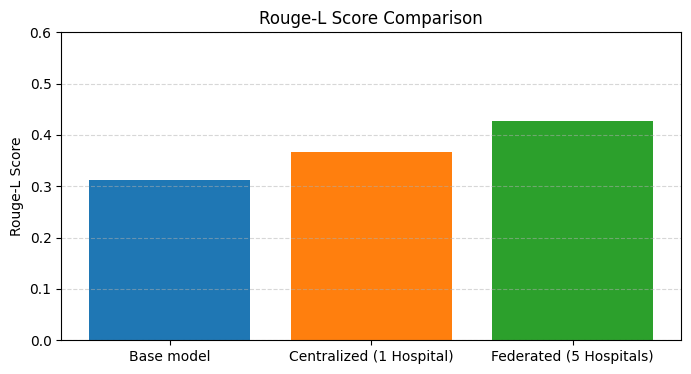

In [23]:
plt.figure(figsize=(8, 4))

bars = plt.bar(labels, rouge_l_scores, color=colors)

plt.title('Rouge-L Score Comparison')
plt.ylabel('Rouge-L Score')
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Conclusion:

Federated fine-tuning of LLMs unlocks (private) data, that otherwise would not be usable. The outcome is a much more capable model. 